In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from explainers_lib.explainers.native.growing_spheres import GrowingSpheresExplainer
from explainers_lib.model import Model as ExplainerModel
import explainers_lib.model
from explainers_lib.datasets import Dataset

from explainers_lib.explainers.native.wachter import WachterExplainer
from explainers_lib.explainers.native.face import FaceExplainer as NativeFaceExplainer
from explainers_lib.explainers.native.growing_spheres import GrowingSpheresExplainer

from explainers_lib.explainers.celery_explainer import ActionableRecourseExplainer
from explainers_lib.explainers.celery_explainer import FaceExplainer
from explainers_lib.explainers.celery_explainer import DiceExplainer
from explainers_lib.explainers.celery_explainer import AlibiCFProto
from explainers_lib.explainers.celery_explainer import AlibiCFRL

from explainers_lib.aggregators import Pareto, All
from explainers_lib.datasets import Dataset
from explainers_lib.ensemble import Ensemble


/home/berni/education/counterfactuals/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class TransConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(3,   32),   # 128 -> 64
            ConvBlock(32,  64),   # 64 -> 32
            ConvBlock(64,  128),  # 32 -> 16
            ConvBlock(128, 256),  # 16 -> 8
            ConvBlock(256, 512),  # 8 W-> 4
            ConvBlock(512, 512),  # 4 -> 2
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, latent_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512 * 2 * 2),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            TransConvBlock(512, 512),   # 2 → 4
            TransConvBlock(512, 512),   # 4 → 8
            TransConvBlock(512, 256),   # 8 → 16
            TransConvBlock(256, 128),   # 16 → 32
            TransConvBlock(128, 64),    # 32 → 64
            TransConvBlock(64, 32),     # 64 → 128
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 2, 2)
        x = self.decoder(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = Encoder(latent_dim).to(device)
        self.decoder = Decoder(latent_dim).to(device)

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        flatten_dim = 32 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [5]:
import torch

autoencoder = Autoencoder(latent_dim=128).to(device)

weights = torch.load("autoencoder_celeba_best.pth", map_location=device)

autoencoder.load_state_dict(weights)

autoencoder.eval()


Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): ConvBlock(
        (block): Sequential(
          (0): C

In [6]:
cnn = CNN().to(device)
cnn_weights = torch.load("models/torch_cnn_celeba_paper_smile_only.pth", map_location=device)
cnn.load_state_dict(cnn_weights)
cnn.eval()


CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [7]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class TransConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(3,   32),   # 128 -> 64
            ConvBlock(32,  64),   # 64 -> 32
            ConvBlock(64,  128),  # 32 -> 16
            ConvBlock(128, 256),  # 16 -> 8
            ConvBlock(256, 512),  # 8 W-> 4
            ConvBlock(512, 512),  # 4 -> 2
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, latent_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512 * 2 * 2),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            TransConvBlock(512, 512),   # 2 → 4
            TransConvBlock(512, 512),   # 4 → 8
            TransConvBlock(512, 256),   # 8 → 16
            TransConvBlock(256, 128),   # 16 → 32
            TransConvBlock(128, 64),    # 32 → 64
            TransConvBlock(64, 32),     # 64 → 128
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 2, 2)
        x = self.decoder(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = Encoder(latent_dim).to(device)
        self.decoder = Decoder(latent_dim).to(device)

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [11]:
from pickle import load

with open("results/celeba_ensemble.pkl", "rb") as f:
    cfes = load(f)  

print(cfes)


[Counterfactual(original_data=array([ 0.3623061 ,  0.5713311 ,  0.407284  ,  0.10398344, -0.21110435,
        0.3221462 , -0.19710131,  0.26138392, -0.4171046 , -0.61215514,
        0.19767006, -0.07036845,  0.05551278, -0.10865308,  0.27833217,
        0.28493267,  0.2048111 ,  0.30309698, -0.36733767, -0.2571394 ,
       -0.44155434, -0.2262083 , -0.01560668, -0.27480975,  0.50871474,
       -0.5261651 , -0.38149208, -0.37664703,  0.09673144,  0.02808866,
        0.09117214, -0.15857548, -0.328715  , -0.05295929, -0.09080423,
        0.13165693,  0.1326296 ,  0.46644318, -0.43277252,  0.176536  ,
        0.23927587, -0.4406913 ,  0.06283499,  0.04417584, -0.22479652,
        0.09962556,  0.25740093, -0.42043516,  0.50013226,  0.4317913 ,
       -0.5101254 , -0.19107375, -0.3425098 ,  0.42918047, -0.41487992,
       -0.398133  ,  0.69695127,  0.6859611 , -0.12421715,  0.22707793,
       -0.12903719,  0.03801167, -0.5147014 , -0.23001952,  0.23518683,
       -0.43596423,  0.02857633,  

In [16]:

class_map = {
    0: "brak uśmiechu",
    1: "uśmiech",
}


In [ ]:
def plot_cfes(cfes):
    n = len(cfes)
    plt.figure(figsize=(10, 4 * n))
    for i in range(n):
        cf = cfes[i]

        # ---- ORIGINAL RECONSTRUCTION ----
        org_latent = torch.tensor(cf.original_data, dtype=torch.float32, device=device).unsqueeze(0)
        org_recon = autoencoder.decoder(org_latent)      # shape [1, 3, 128, 128]

        org_recon_np = org_recon.detach().cpu().permute(0, 2, 3, 1).numpy()[0]

        # map from [-1, 1] → [0, 1]
        org_recon_np = (org_recon_np + 1) / 2
        org_recon_np = org_recon_np.clip(0, 1)

        # ---- COUNTERFACTUAL RECONSTRUCTION ----
        cf_latent = torch.tensor(cf.data, dtype=torch.float32, device=device).unsqueeze(0)
        cfe_recon = autoencoder.decoder(cf_latent)

        cfe_recon_np = cfe_recon.detach().cpu().permute(0, 2, 3, 1).numpy()[0]
        cfe_recon_np = (cfe_recon_np + 1) / 2
        cfe_recon_np = cfe_recon_np.clip(0, 1)

        # ---- PLOTTING ----
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(org_recon_np)
        plt.title(class_map[cf.original_class])
        plt.axis("off")

        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(cfe_recon_np)
        plt.title(class_map[cf.target_class])
        plt.axis("off")

    plt.tight_layout()
    plt.axis("off")
    plt.show()


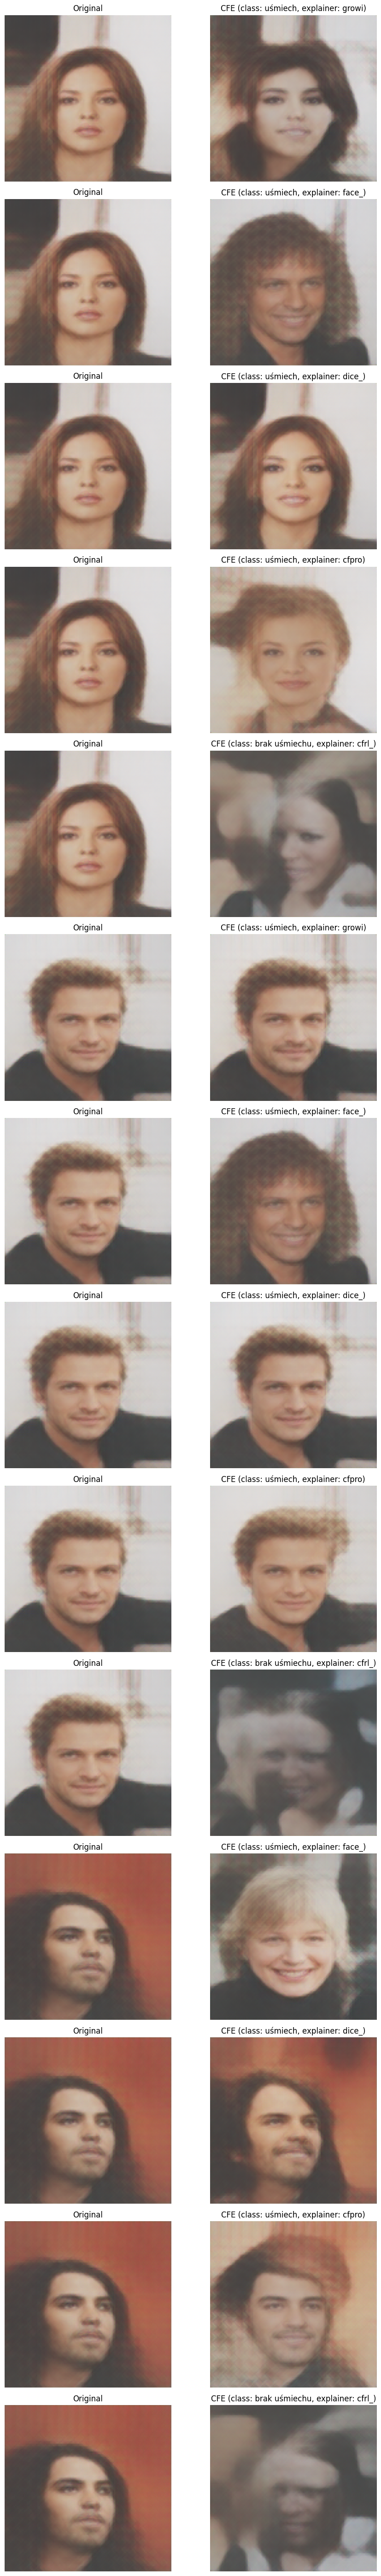

In [18]:
plot_cfes(cfes)
